In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = './test.csv'
max_age = 3.

In [10]:
pop = pd.read_csv(path)
pop.parent_id[pop.parent_id < 0] = np.nan

n_ages = pop.age.unique().size
print n_ages

10


/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## track traits per age over time

In [11]:
def get_snap_pops(pop, n_snaps):
    snap_pops = [pop[pop.birth_date == 0]]
    timepoints = np.linspace(0, max(pop.birth_date.max(), pop.death_date.max()), n_snaps+1)
    for i in range(1, n_snaps):
        snap_pops.append(pop[np.logical_and(pop.birth_date <= timepoints[i], np.logical_or(pop.death_date > timepoints[i], np.isnan(pop.death_date)))])
    return snap_pops

In [12]:
def my_unique(agerange, ages):
    values, counts = np.unique(ages,return_counts=True)
    missing = np.setdiff1d(agerange, values)
    values = np.concatenate((values, missing))
    counts = np.concatenate((counts, np.zeros(len(missing)).astype(int)))
    sort_ix = np.argsort(values)
    return counts[sort_ix]

In [44]:
def my_argmax(arr, axis):
    if np.sum(arr) == 0:
        return len(arr)-1
    else:
        return np.argmax(arr, axis=axis)-1
    
def age_bins(agerange, pop, time):
    ages = time - pop[pop.age==0].birth_date.__array__()
    popsize = pop.id.size / n_ages
    age_bins = agerange[my_argmax(np.tile(agerange,popsize).reshape(popsize,len(agerange)) >= np.repeat(ages,len(agerange)).reshape(popsize,len(agerange)), axis=1)]
    return age_bins

/home/asajina/pyenvs/jupyter/local/lib/python2.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


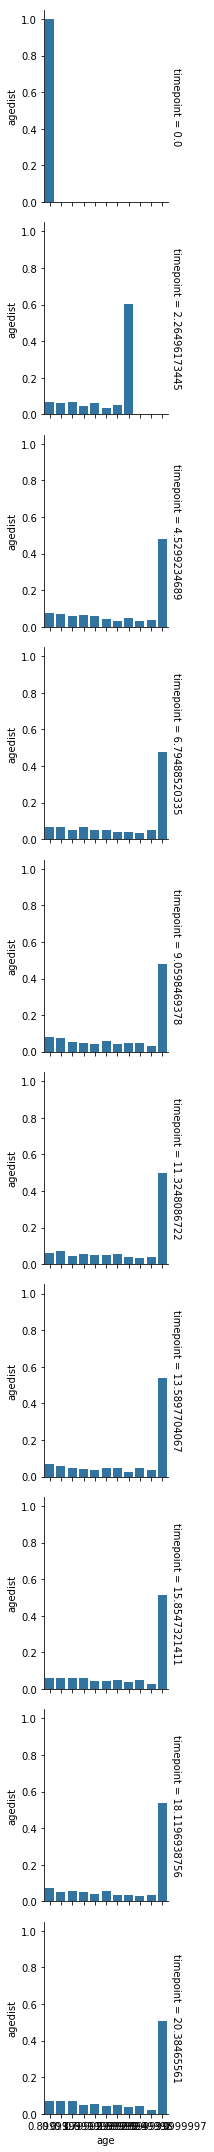

In [52]:
def trait_timeline(pop, n_timepoints=10):
    timepoints = np.linspace(0, max(pop.birth_date.max(), pop.death_date.max()), n_timepoints+1)
    agerange = np.linspace(0, max_age, n_ages+1)
    snap_pops = get_snap_pops(pop, n_timepoints)
    
    # fill in for starting population
    survival = snap_pops[0].groupby('age').mean().survival
    reproduction = snap_pops[0].groupby('age').mean().reproduction
    popsize = [snap_pops[0].id.size / n_ages]
    variance = [0]
    agedist = np.zeros(n_ages+1)
    agedist[0] = 1.
    
    for i in range(1, n_timepoints):
        # traits
        survival = np.hstack((survival, snap_pops[i].groupby('age').mean().survival))
        reproduction = np.hstack((reproduction, snap_pops[i].groupby('age').mean().reproduction))
        # popsize and variance
        popsize.append(snap_pops[i].id.size / n_ages)
        variance.append(np.var(snap_pops[i][snap_pops[i].age == 0].id)) # just variance by ids
        
        # age distribution
        agedist = np.vstack((agedist, my_unique(agerange, age_bins(agerange, snap_pops[i], timepoints[i])) / float(popsize[-1])))
        
    dft = pd.DataFrame()
    dft['age'] = np.tile(np.tile(pop.age.unique(), n_timepoints), 2)
    dft['timepoint'] = np.tile(np.repeat(timepoints[:-1], n_ages), 2)
    dft['trait'] = np.concatenate((survival, reproduction))
    dft['type'] = np.repeat(['survival', 'reproduction'], n_ages * pop.age.unique().size)
    
    dfps = pd.DataFrame()
    dfps['timepoint'] = timepoints[:-1]
    dfps['popsize'] = np.array(popsize)
    dfps['variance'] = np.array(variance)
    
    dfad = pd.DataFrame()
    dfad['age'] = np.tile(agerange, n_timepoints)
    dfad['timepoint'] = np.repeat(timepoints[:-1], n_ages+1)
    dfad['agedist'] = agedist.flatten()
    
    return dft, dfps, dfad

df_traits, df_popsize, df_agedist = trait_timeline(pop)
#sns.relplot(data=df_traits, x='timepoint', y='trait', hue='age', kind='line', col='type')
#sns.relplot(data=df_popsize, x='timepoint', y='popsize')
g = sns.FacetGrid(df_agedist, row='timepoint', margin_titles=True)
g.map(sns.barplot, 'age', 'agedist')

In [6]:
pop[np.logical_and(np.isnan(pop.death_date), pop.birth_date < 1.5)].id.size

8050

In [18]:
pop.birth_date.__array__()

array([ 0.        ,  0.        ,  0.        , ..., 22.64961734,
       22.64961734, 22.64961734])

In [16]:
print pd.__version__

0.23.4
